# Roadmap -- Distortion

This is the real dataset test of [Experiment Distortion](https://github.com/ZhiruiFeng/explorer/blob/master/test/RandomGraph.ipynb).

Here we have our dataset from [DIMACS](http://www.diag.uniroma1.it/challenge9/).

Then we will analysis the distortion on this graph as what we have done on random graph.

In [1]:
# Add libraries
%load_ext autoreload
%autoreload 2
import os, sys
lib_path = os.path.abspath(os.path.join('../'))
sys.path.append(lib_path)

import heuristic.fastmap.utils as utils
from heuristic.fastmap.difastmap import init_dis_store, difastmap_average, difastmap_diff, difastmap_max 
import heuristic.fastmap.analyse as analyse

import matplotlib.pyplot as plt
import networkx as nx
import random
import multiprocessing as mp
import numpy as np
import math
from random import sample

**Load the graph**

In [2]:
filepath = "../data/roadmap/rome99.road"

def readDiGraph_type(infile):
    G = nx.DiGraph()
    with open(infile) as f:
        l = f.readline()
        while l:
            if l[0] != 'a':
                l = f.readline()
                continue
            items = l.strip().split()
            if len(items) == 4:
                node1, node2, weight = items[1:]
            elif len(items) == 3:
                node1, node2 = items[1:]
                wight = 1.0
            G.add_edge(node1, node2, weight=float(weight))
            l = f.readline()
    return G

In [3]:
G = readDiGraph_type(filepath)

A strongly connected graph.
3353
8859


In [40]:
utils.connectivity_info(G)
countn = G.number_of_nodes()
counte = G.number_of_edges()
density = float(counte)/(countn * (countn-1))
print(countn)
print(counte)
print(density)

A strongly connected graph.
3353
8859
0.0007882194337418775


In [24]:
def thedistance_info(G):
    dis = []
    span = G.number_of_nodes() / 100
    nodelist = list(G.nodes())
    for i in range(G.number_of_nodes()):
        if i%(span) == 0:
            sys.stdout.write("\r {}%".format(int(i/span)))
        length = nx.single_source_dijkstra_path_length(G, nodelist[i])
        dis.extend(list(length.values()))
    plt.hist(dis)
    plt.xlabel('distance')
    plt.ylabel('count (persents)')
    plt.title('Statistic of pair distances')
    plt.show()

 0%

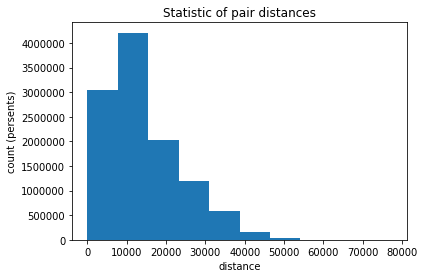

In [26]:
thedistance_info(G)

In [12]:
dijkstra_path_length = {}
span = G.number_of_nodes() / 20
i = 0
for node in G.nodes:
    i += 1
    if i%span == 0:
        print("\r {}% Finished".format(int(i/span)*20))
    dijkstra_path_length[node] = nx.single_source_dijkstra_path_length(G, node)

## Distortion of embedding average and max

In [28]:
def meta_distortion_analyse(i):
    global G, embedding, subset, alg, variant, threshold
    node_1=subset[i]
    emb_1 = np.array(embedding[node_1])
    length = dijkstra_path_length[node_1]
    sigma = 0
    ave_d = 0
    larger = 0
    equal = 0
    smaller = 0
    for j in range(i+1, len(subset)):
        node_2 = subset[j]
        emb_2 = np.array(embedding[node_2])
        distance = length[node_2]
        if variant == 'undirected':
            target_dis = distance
        elif variant == 'average':
            distance_reverse = dijkstra_path_length[node_2][node_1]
            target_dis = (float(distance) + float(distance_reverse))/2
        elif variant == 'max':
            distance_reverse = dijkstra_path_length[node_2][node_1]
            target_dis = max(float(distance), float(distance_reverse))
        elif variant == 'diff':
            distance_reverse = dijkstra_path_length[node_2][node_1]
            target_dis = abs(float(distance) - float(distance_reverse))/2
        if alg == 'L1':
            embdis = np.sum(np.abs(emb_1-emb_2))
        elif alg == 'L2':
            embdis = math.sqrt(np.dot(emb_1-emb_2, emb_1-emb_2))
        if embdis > target_dis + threshold:
            larger += 1
        elif embdis < target_dis - threshold:
            smaller += 1
        else:
            equal += 1
        sigma += (target_dis-embdis)*(target_dis-embdis)
        ave_d += target_dis
    return [sigma, ave_d, larger, equal, smaller]

def distortion_analyse_mp(G, embedding, subset, alg, variant, threshold):
    input_set = list(range(len(subset)))
    sigma = 0
    ave_d = 0
    larger = 0
    equal = 0
    smaller = 0
    pool_size = mp.cpu_count() * 2
    print("Pool size: {}".format(pool_size))
    pool = mp.Pool(processes=pool_size)
    pool_outputs = pool.map(meta_distortion_analyse, input_set)
    pool.close()
    pool.join()
    # Sum the result of metacalculation
    pool_outputs = np.array(pool_outputs)
    #print(pool_outputs)
    sigma, ave_d, larger, equal, smaller = np.sum(pool_outputs, 0)
    base = float(S)*float(S-1)/2
    sigma = math.sqrt(float(sigma)/base)
    ave_d = float(ave_d)/base

    return float(sigma)/ave_d, larger, equal, smaller

In [30]:
klist = [2, 3, 4, 5, 6, 7]
for K in klist:
    print("#########Test for K:{}".format(K))
    epsilon = 0.01
    threshold = 20
    alg = 'L2'
    dis_store = init_dis_store(G)
    embedding = difastmap_average(G, K, epsilon, dis_store, alg)
    S = int(2000)
    subset = sample(list(G.nodes()), S)
    variant = 'average'
    results = distortion_analyse_mp(G, embedding, subset, alg, variant, threshold)
    print(results)

#########Test for K:2
Pool size: 8
(0.14753441008895846, 262362.0, 18165.0, 1718473.0)
#########Test for K:3
Pool size: 8
(0.13458572732987661, 536856.0, 23327.0, 1438817.0)
#########Test for K:4
Pool size: 8
(0.10645171370658212, 841867.0, 27948.0, 1129185.0)
#########Test for K:5
Pool size: 8
(0.09620072616933154, 1159237.0, 36293.0, 803470.0)
#########Test for K:6
Pool size: 8
(0.10711903341807717, 1421462.0, 32277.0, 545261.0)
#########Test for K:7
Pool size: 8
(0.12264719692356224, 1463667.0, 30340.0, 504993.0)


In [31]:
klist = [1, 2, 3, 4, 5]
for K in klist:
    print("#########Test for K:{}".format(K))
    epsilon = 0.01
    threshold = 20
    alg = 'L1'
    dis_store = init_dis_store(G)
    embedding = difastmap_average(G, K, epsilon, dis_store, alg)
    S = int(2000)
    subset = sample(list(G.nodes()), S)
    variant = 'average'
    results = distortion_analyse_mp(G, embedding, subset, alg, variant, threshold)
    print(results)

#########Test for K:1
Pool size: 8
(0.7029439363485331, 0.0, 3574.0, 1995426.0)
#########Test for K:2
Pool size: 8
(0.20217408298685963, 1092892.0, 19655.0, 886453.0)
#########Test for K:3
Pool size: 8
(0.3197409135873016, 1670087.0, 10217.0, 318696.0)
#########Test for K:4
Pool size: 8
(0.4488241591422769, 1814951.0, 6080.0, 177969.0)
#########Test for K:5
Pool size: 8
(0.44439968940757674, 1909062.0, 4960.0, 84978.0)


In [32]:
klist = [2, 3, 4, 5, 6, 7, 8]
for K in klist:
    print("#########Test for K:{}".format(K))
    epsilon = 0.01
    threshold = 20
    alg = 'L2'
    dis_store = init_dis_store(G)
    embedding = difastmap_max(G, K, epsilon, dis_store, alg)
    S = int(2000)
    subset = sample(list(G.nodes()), S)
    variant = 'max'
    results = distortion_analyse_mp(G, embedding, subset, alg, variant, threshold)
    print(results)

#########Test for K:2
Pool size: 8
(0.14551796869002195, 253719.0, 17190.0, 1728091.0)
#########Test for K:3
Pool size: 8
(0.14049884731936232, 511509.0, 21151.0, 1466340.0)
#########Test for K:4
Pool size: 8
(0.10442753805269389, 821491.0, 26635.0, 1150874.0)
#########Test for K:5
Pool size: 8
(0.09543376317429426, 1058416.0, 35039.0, 905545.0)
#########Test for K:6
Pool size: 8
(0.11009815662259594, 1286097.0, 35414.0, 677489.0)
#########Test for K:7
Pool size: 8
(0.11364427522288151, 1454073.0, 32879.0, 512048.0)
#########Test for K:8
Pool size: 8
(0.13089348080422272, 1595078.0, 27100.0, 376822.0)


In [34]:
klist = [1, 2, 3, 4, 5, 6, 7, 8]
for K in klist:
    print("#########Test for K:{}".format(K))
    epsilon = 0.01
    threshold = 20
    alg = 'L1'
    dis_store = init_dis_store(G)
    embedding = difastmap_max(G, K, epsilon, dis_store, alg)
    S = int(2000)
    subset = sample(list(G.nodes()), S)
    variant = 'max'
    results = distortion_analyse_mp(G, embedding, subset, alg, variant, threshold)
    print(results)

#########Test for K:1
Pool size: 8
(0.7006853318997907, 0.0, 3970.0, 1995030.0)
#########Test for K:2
Pool size: 8
(0.1951073315962774, 1094620.0, 18847.0, 885533.0)
#########Test for K:3
Pool size: 8
(0.3098353714672583, 1642683.0, 10463.0, 345854.0)
#########Test for K:4
Pool size: 8
(0.37335497654228117, 1797088.0, 6749.0, 195163.0)
#########Test for K:5
Pool size: 8
(0.49941973945131385, 1911134.0, 3859.0, 84007.0)
#########Test for K:6
Pool size: 8
(0.4979002315920678, 1930669.0, 3574.0, 64757.0)
#########Test for K:7
Pool size: 8
(0.6671494000955254, 1956782.0, 2354.0, 39864.0)
#########Test for K:8
Pool size: 8
(0.7589615902535747, 1993614.0, 481.0, 4905.0)


**Conclusion**

Except that $K$ here is very small in roadmap compared with $K$ in the random graph. And $L_2$ performs way better than $L_1$.

**Attention:** Figure out the theoretical reason behind is very important in this period.

## Test the distortion of embedding min

In [36]:
def meta_distortion_min(i):
    global G, embedding_aver, embedding_max, subset, alg
    node_1=subset[i]
    emb_aver_1 = np.array(embedding_aver[node_1])
    emb_max_1 = np.array(embedding_max[node_1])
    length = dijkstra_path_length[node_1]
    sigma = 0
    ave_d = 0
    for j in range(i+1, len(subset)):
        node_2 = subset[j]
        emb_aver_2 = np.array(embedding_aver[node_2])
        emb_max_2 = np.array(embedding_max[node_2])
        distance = length[node_2]
        distance_reverse = dijkstra_path_length[node_2][node_1]
        target_dis = min(float(distance), float(distance_reverse))
        if alg == 'L1':
            embdis_aver = np.sum(np.abs(emb_aver_1-emb_aver_2))
            embdis_max = np.sum(np.abs(emb_max_1-emb_max_2))
        elif alg == 'L2':
            embdis_aver = math.sqrt(np.dot(emb_aver_1-emb_aver_2, emb_aver_1-emb_aver_2))
            embdis_max = math.sqrt(np.dot(emb_max_1-emb_max_2, emb_max_1-emb_max_2))
        embdis = 2.0*embdis_aver - embdis_max
        sigma += (target_dis-embdis)*(target_dis-embdis)
        ave_d += target_dis
    return [sigma, ave_d]

def distortion_min_mp(G, embedding_aver, embedding_max, subset, alg):
    input_set = list(range(len(subset)))
    sigma = 0
    ave_d = 0
    pool_size = mp.cpu_count() * 2
    print("Pool size: {}".format(pool_size))
    pool = mp.Pool(processes=pool_size)
    pool_outputs = pool.map(meta_distortion_min, input_set)
    pool.close()
    pool.join()
    # Sum the result of metacalculation
    pool_outputs = np.array(pool_outputs)
    #print(pool_outputs)
    sigma, ave_d = np.sum(pool_outputs, 0)
    base = float(S)*float(S-1)/2
    sigma = math.sqrt(float(sigma)/base)
    ave_d = float(ave_d)/base
    return float(sigma)/ave_d

In [37]:
klist = [2, 3, 4, 5, 6]
for K1 in klist:
    for K2 in klist:
        print("#########Test for K1:{}, K2:{}".format(K1, K2))
        epsilon = 0.01
        alg = 'L2'
        dis_store = init_dis_store(G)
        embedding_aver = difastmap_average(G, K1, epsilon, dis_store, alg)
        embedding_max = difastmap_max(G, K2, epsilon, dis_store, alg)
        S = int(1000)
        subset = sample(list(G.nodes()), S)
        results = distortion_min_mp(G, embedding_aver, embedding_max, subset, alg)
        print(results)

#########Test for K1:2, K2:2
Pool size: 8
0.15064051237550247
#########Test for K1:2, K2:3
Pool size: 8
0.26570363980204165
#########Test for K1:2, K2:4
Pool size: 8
0.30062672619827585
#########Test for K1:2, K2:5
Pool size: 8
0.29712011033595653
#########Test for K1:2, K2:6
Pool size: 8
0.30585683487217474
#########Test for K1:3, K2:2
Pool size: 8
0.16502319890265318
#########Test for K1:3, K2:3
Pool size: 8
0.24484426500293863
#########Test for K1:3, K2:4
Pool size: 8
0.1314118973719322
#########Test for K1:3, K2:5
Pool size: 8
0.1627192341129002
#########Test for K1:3, K2:6
Pool size: 8
0.16012605000200728
#########Test for K1:4, K2:2
Pool size: 8
0.2096425797982488
#########Test for K1:4, K2:3
Pool size: 8
0.1475809258500118
#########Test for K1:4, K2:4
Pool size: 8
0.10268080601887823
#########Test for K1:4, K2:5
Pool size: 8
0.12975032869128378
#########Test for K1:4, K2:6
Pool size: 8
0.14354201316874432
#########Test for K1:5, K2:2
Pool size: 8
0.22636509672573898
#########Tes

**Conclusion**

The approximation of the `min`, which didn't get directly, is also fairly promissing. 

The the whole precision line on the accuracy of predicting the comparison reasult of $d_{ij}$ and $d_{ji}$.

## Test the distortion of differential heuristic

In [38]:
def edgebound(pivots, pivots_dis_i, pivots_dis_j):
    upper_ij = float('inf')
    lower_ij = 0    
    for p in pivots:
        dip = pivots_dis_i[p]
        dpj = pivots_dis_j['-'+str(p)]
        djp = pivots_dis_j[p]
        dpi = pivots_dis_i['-'+str(p)]
        temp_upper_ij = dip + dpj
        if temp_upper_ij < upper_ij:
            upper_ij = temp_upper_ij
        if dip > djp:
            temp_ij = dip - djp
            if temp_ij > lower_ij:
                lower_ij = temp_ij
        if dpj > dpi:
            temp_ij = dpj - dpi
            if temp_ij > lower_ij:
                lower_ij = temp_ij
    return lower_ij, upper_ij

def meta_distortion_dh(i):
    global G, dis_store, subset, pick
    node_1=subset[i]
    emb_1 = np.array(embedding[node_1])
    length = dijkstra_path_length[node_1]
    sigma = 0
    ave_d = 0
    for j in range(i+1, len(subset)):
        node_2 = subset[j]
        emb_2 = np.array(embedding[node_2])
        distance = length[node_2]
        target_dis = distance
        lower, upper = edgebound(dis_store['pivots'], dis_store[node_1], dis_store[node_2])
        if pick == 'upper':
            embdis = upper
        elif pick == 'lower':
            embdis = lower
        elif pick == 'median':
            embdis = (float(upper)+float(lower))/2
        sigma += (target_dis-embdis)*(target_dis-embdis)
        ave_d += target_dis
    return [sigma, ave_d]

def distortion_dh_mp(G, dis_store, subset, pick='upper'):
    input_set = list(range(len(subset)))
    sigma = 0
    ave_d = 0
    pool_size = mp.cpu_count() * 2
    print("Pool size: {}".format(pool_size))
    pool = mp.Pool(processes=pool_size)
    pool_outputs = pool.map(meta_distortion_dh, input_set)
    pool.close()
    pool.join()
    # Sum the result of metacalculation
    pool_outputs = np.array(pool_outputs)
    #print(pool_outputs)
    sigma, ave_d = np.sum(pool_outputs, 0)
    base = float(S)*float(S-1)/2
    sigma = math.sqrt(float(sigma)/base)
    ave_d = float(ave_d)/base
    return float(sigma)/ave_d

In [39]:
klist = [3, 4, 5, 6, 7, 8, 9, 10]
for K in klist:
    print("!!!!!!!!!The number of K: {}")
    picklist = ['upper', 'lower', 'median']
    for pick in picklist:
        print("#########Test for differential heuristic:{}".format(pick))
        epsilon = 0.01
        alg = 'L2'
        dis_store = init_dis_store(G)
        embedding = difastmap_max(G, K, epsilon, dis_store, alg)
        S = int(1000)
        subset = sample(list(G.nodes()), S)
        results = distortion_dh_mp(G, dis_store, subset, pick)
        print(results)

!!!!!!!!!The number of K: 3
#########Test for differential heuristic:upper
Pool size: 8
2.767465934235497
#########Test for differential heuristic:lower
Pool size: 8
0.11128704097827882
#########Test for differential heuristic:median
Pool size: 8
1.2884792675942993
!!!!!!!!!The number of K: 4
#########Test for differential heuristic:upper
Pool size: 8
2.423530217559104
#########Test for differential heuristic:lower
Pool size: 8
0.09709239010206906
#########Test for differential heuristic:median
Pool size: 8
1.216886150703621
!!!!!!!!!The number of K: 5
#########Test for differential heuristic:upper
Pool size: 8
2.2292568099265515
#########Test for differential heuristic:lower
Pool size: 8
0.08541195358246231
#########Test for differential heuristic:median
Pool size: 8
1.1626184657890706
!!!!!!!!!The number of K: 6
#########Test for differential heuristic:upper
Pool size: 8
2.0761918855270025
#########Test for differential heuristic:lower
Pool size: 8
0.0765771059215195
#########Test fo

**Conclusion**

While using the differential heuristic, the lower bound is amazingly good, and it even keeps the property of admissibility.

**Later planning**

1. I have a theory: the distrotion here has a very tight relation with the scale of the weight of the edge, so we can adjust it to see the change of performance. (make the weight of the edges closer, to see whether it's the sturcture of the graph of just the weight that plays an important role.)
2. Try to analyse the combination, and the details in different situations.
3. **Try to analyse the reason why differential heuristic can performs so good, because it's kind of counterintuitive.**

## Fine-tune the approximation of distances.

In [41]:
def edgebound(pivots, pivots_dis_i, pivots_dis_j):
    upper_ij = float('inf')
    lower_ij = 0    
    for p in pivots:
        dip = pivots_dis_i[p]
        dpj = pivots_dis_j['-'+str(p)]
        djp = pivots_dis_j[p]
        dpi = pivots_dis_i['-'+str(p)]
        temp_upper_ij = dip + dpj
        if temp_upper_ij < upper_ij:
            upper_ij = temp_upper_ij
        if dip > djp:
            temp_ij = dip - djp
            if temp_ij > lower_ij:
                lower_ij = temp_ij
        if dpj > dpi:
            temp_ij = dpj - dpi
            if temp_ij > lower_ij:
                lower_ij = temp_ij
    return lower_ij, upper_ij

def compare(pivots, pivots_dis_i, pivots_dis_j, disaver, dismax, realdis):
    lower, upper = edgebound(pivots, pivots_dis_i, pivots_dis_j)
    median = (float(lower)+float(upper))/2
    dismin = 2.0*disaver - dismax
    if dismin < 0:
        dismin = 0
    if upper <= dismin:
        state = 1
        distune = upper
        substate = 1 + np.argmin(np.abs(np.array([lower, median, upper])-realdis))
    elif upper > dismin and upper <= disaver and lower <=dismin:
        state = 2
        distune = dismin
        substate = 4 + np.argmin(np.abs(np.array([lower, dismin, median, upper])-realdis))
    elif upper > disaver and upper <= dismax and lower <=dismin: # spe
        state = 3
        distune = median
        substate = 8 + np.argmin(np.abs(np.array([lower, dismin, median, disaver, upper])-realdis))
    elif upper > dismax and lower <=dismin: # spe
        state = 4
        distune = disaver
        substate = 13 + np.argmin(np.abs(np.array([lower, dismin, median, disaver, dismax, upper])-realdis))
    elif upper <= disaver and lower > dismin:
        state = 5
        distune = lower
        substate = 19 + np.argmin(np.abs(np.array([lower, median, upper])-realdis))
    elif upper > disaver and upper <= dismax and lower <= disaver and lower > dismin:
        state = 6
        distune = disaver
        substate = 22 + np.argmin(np.abs(np.array([lower, median, disaver, upper])-realdis))
    elif upper > dismax and lower <= disaver and lower > dismin: #spe
        state = 7
        distune = dismax
        substate = 26 + np.argmin(np.abs(np.array([lower, disaver, median, dismax, upper])-realdis))
    elif upper <= dismax and lower > disaver:
        state = 8
        distune = upper
        substate = 31 + np.argmin(np.abs(np.array([lower, median, upper])-realdis))
    elif upper > dismax and lower <= dismax:
        state = 9
        distune = dismax
        substate = 34 + np.argmin(np.abs(np.array([lower, median, dismax, upper])-realdis))
    elif lower > dismax:
        state = 10
        distune = lower
        substate = 38 + np.argmin(np.abs(np.array([lower, median, upper])-realdis))
    else:
        state = 0
        distune = disaver
    return state, distune, substate

def meta_fastmap_dh(i):
    global G, embedding_aver, embedding_max, subset, alg
    node_1=subset[i]
    emb_aver_1 = np.array(embedding_aver[node_1])
    emb_max_1 = np.array(embedding_max[node_1])
    length = dijkstra_path_length[node_1]
    sigma = 0
    ave_d = 0
    compare_state = []
    for t in range(11):
        compare_state.append(0)
    compare_substate = []
    for t in range(41):
        compare_substate.append(0)
    for j in range(len(subset)):
        if i == j:
            continue
        node_2 = subset[j]
        emb_aver_2 = np.array(embedding_aver[node_2])
        emb_max_2 = np.array(embedding_max[node_2])
        distance = length[node_2]
        target_dis = distance
        if alg == 'L1':
            embdis_aver = np.sum(np.abs(emb_aver_1-emb_aver_2))
            embdis_max = np.sum(np.abs(emb_max_1-emb_max_2))
        elif alg == 'L2':
            embdis_aver = math.sqrt(np.dot(emb_aver_1-emb_aver_2, emb_aver_1-emb_aver_2))
            embdis_max = math.sqrt(np.dot(emb_max_1-emb_max_2, emb_max_1-emb_max_2))
        state, tunedis, substate = compare(dis_store['pivots'], dis_store[node_1], dis_store[node_2], embdis_aver, embdis_max, target_dis)
        compare_state[state] += 1
        compare_substate[substate] += 1 
        sigma += (target_dis-tunedis)*(target_dis-tunedis)
        ave_d += target_dis
    output = list([sigma, ave_d])
    for n in compare_state:
        output.append(n)
    for n in compare_substate:
        output.append(n)
    return output

def draw_distribution(states, xl, yl, title):
    s = sum(states)
    x = list(range(len(states)))
    y = []
    for i in range(len(states)):
        y.append(float(states[i])/s)
    plt.plot(x,y,'r-o', linewidth=1)
    plt.xlabel(xl)
    plt.ylabel(yl)
    plt.title(title)
    plt.show()
    
def fastmap_dh_distribution_mp(G, embedding_aver, embedding_max, subset, alg):
    input_set = list(range(len(subset)))
    sigma = 0
    ave_d = 0
    pool_size = mp.cpu_count() * 2
    print("Pool size: {}".format(pool_size))
    pool = mp.Pool(processes=pool_size)
    pool_outputs = pool.map(meta_fastmap_dh, input_set)
    pool.close()
    pool.join()
    # Sum the result of metacalculation
    pool_outputs = np.array(pool_outputs)
    #print(pool_outputs)
    resultsum = np.sum(pool_outputs, 0)
    sigma, ave_d = resultsum[:2]
    states = resultsum[2:13]
    substates = resultsum[13:]
    xlabel = 'states'
    ylabel = 'count (persents)'
    title = 'Distribution of DH and FastMap result'
    s = sum(states)
    x = list(range(len(states)))
    y = []
    for i in range(len(states)):
        y.append(float(states[i])/s)
    s_sub = sum(substates)
    x_sub =[0,
            0.75, 1, 1.25,
            1.7, 1.9, 2.1, 2.3,
            2.6, 2.8, 3, 3.2, 3.4,
            3.5, 3.7, 3.9, 4.1, 4.3, 4.5,
            4.75, 5, 5.25,
            5.7, 5.9, 6.1, 6.3,
            6.6, 6.8, 7, 7.2, 7.4,
            7.75, 8, 8.25,
            8.7, 8.9, 9.1, 9.3,
            9.75, 10, 10.25]
    y_sub = []
    for i in range(len(substates)):
        y_sub.append(float(substates[i])/s_sub)
    plt.plot(x,y,'r-o', linewidth=1)
    plt.plot(x_sub, y_sub, 'g-*')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.show()
    
    plt.figure(1)
    adjlist = [3,4,5,6,3,4,5,3,4,3]
    for i in range(1,11):
        tempx = [i-1, i, i+1]
        tempy = [0, y[i], 0]
        tempxsub = x_sub[sum(adjlist[:i-1])+1:sum(adjlist[:i])+1]
        tempysub = y_sub[sum(adjlist[:i-1])+1:sum(adjlist[:i])+1]
        plt.subplot(4, 3, i)
        plt.plot(tempx,tempy,'r-o', linewidth=1)
        plt.plot(tempxsub, tempysub, 'g-*')
    plt.show()
    
    upper_states = [0,0,0,0]
    upper_states[0] += states[1]
    upper_states[1] += states[2] + states[5]
    upper_states[2] += states[3] + states[6] + states[8]
    upper_states[3] += states[4] + states[7] + states[9] + states[10]
    title = 'Upper Distribution of DH and FastMap result'
    draw_distribution(upper_states, xlabel, ylabel, title)
    
    lower_states = [0,0,0,0]
    lower_states[0] += states[1] + states[2] + states[3] + states[4]
    lower_states[1] += states[5] + states[6] + states[7]
    lower_states[2] += states[8] + states[9]
    lower_states[3] += states[10]
    title = 'Lower Distribution of DH and FastMap result'
    draw_distribution(lower_states, xlabel, ylabel, title) 
    
    base = float(S)*float(S-1)
    sigma = math.sqrt(float(sigma)/base)
    ave_d = float(ave_d)/base
    return float(sigma)/ave_d

Pool size: 8


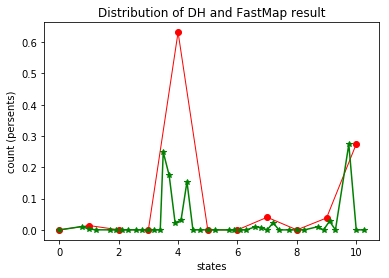

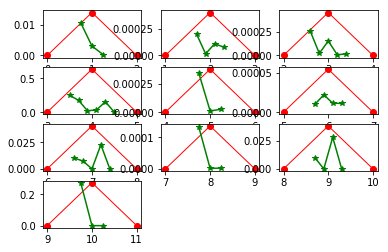

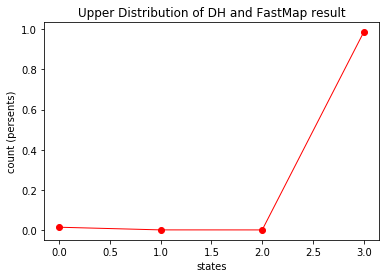

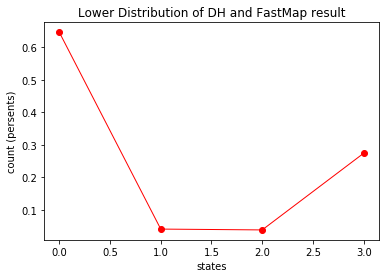

0.09016852256243267
#########Test for differential heuristic:upper
Pool size: 8
2.3812965240791844
#########Test for differential heuristic:lower
Pool size: 8
0.09803246291299583
#########Test for differential heuristic:median
Pool size: 8
1.1659140750765817


In [44]:
epsilon = 0.01
alg = 'L2'
dis_store = init_dis_store(G)
embedding_aver = difastmap_average(G, 4, epsilon, dis_store, alg)
embedding_max = difastmap_max(G, 4, epsilon, dis_store, alg)
S = int(2000)
subset = sample(list(G.nodes()), S)
results = fastmap_dh_distribution_mp(G, embedding_aver, embedding_max, subset, alg)
print(results)
picklist = ['upper', 'lower', 'median']
for pick in picklist:
    print("#########Test for differential heuristic:{}".format(pick))
    results = distortion_dh_mp(G, dis_store, subset, pick)
    print(results)

**Summary:**

1. The result show most of the time, the `lower bound` has the better approximation of the real distance, which matches the restults of distortion. 
2. And here we can see the `upper bound` is always large than our prediction of `dismax`, which is reasonable.
3. However, why there are a large proportion of `lower bound` greater than the `dismax`?
4. We still need more information to see how to improve the approximation further more. Because currently, the dominate situation both shows our approximation from embedding could not help make a better choice.
5. And because the orignal distortion by DH is already very good, and even better than the approximation, so we need rather improves the approximation from FastMap, or find more usable information beyond the pure distance in Euclidean space. 

## Test the influence of edge weights 

In [50]:
filepath = "../data/roadmap/rome99.road"

def readDiGraph_type_scaled(infile, rate):
    G = nx.DiGraph()
    with open(infile) as f:
        l = f.readline()
        while l:
            if l[0] != 'a':
                l = f.readline()
                continue
            items = l.strip().split()
            if len(items) == 4:
                node1, node2, weight = items[1:]
                weight = float(weight) * rate
            elif len(items) == 3:
                node1, node2 = items[1:]
                wight = 1.0
            G.add_edge(node1, node2, weight=float(weight))
            l = f.readline()
    return G

In [51]:
rate = 0.01
G = readDiGraph_type_scaled(filepath, rate)

In [52]:
dijkstra_path_length = {}
span = G.number_of_nodes() / 20
i = 0
for node in G.nodes:
    i += 1
    if i%span == 0:
        print("\r {}% Finished".format(int(i/span)*20))
    dijkstra_path_length[node] = nx.single_source_dijkstra_path_length(G, node)

In [53]:
def thedistance_info(G):
    dis = []
    nodelist = list(G.nodes())
    for i in range(G.number_of_nodes()):
        length = dijkstra_path_length[nodelist[i]]
        dis.extend(list(length.values()))
    plt.hist(dis)
    plt.xlabel('distance')
    plt.ylabel('count (persents)')
    plt.title('Statistic of pair distances')
    plt.show()

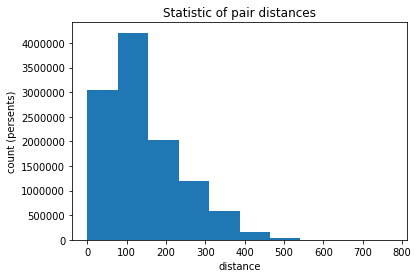

In [55]:
thedistance_info(G)